# Polarization example (GRB) - azimuthal scattering angle distribution (ASAD) method

This notebook fits the polarization fraction and angle of a GRB simulated using MEGAlib and combined with background. It's assumed that the start time, duration, localization, and spectrum of the GRB are already known. The GRB was simulated with 70% polarization at an angle of 110 degrees in the RelativeX convention, which corresponds to 83.015 degrees in the IAU convention.

The data to run this notebook, including GRBs simulated on-axis, 10 degrees off-axis, and 20 degrees off-axis, can be found on the COSI Pipeline Google Drive: https://drive.google.com/drive/folders/1kCkqQv07APSSlexeuIgK2Jj7eqJzNNgQ. However, with the RelativeZ response, it is not possible to fit the on-axis GRB.

Caveats/limitations:
- Currently, the source must be stationary with respect to the instrument, and the spacecraft must be stationary. The ability to fit the polarization of persistent sources will be added later. 
- The background simulation is used as the background model, and its ASAD is subtracted from the source+background ASAD.   

In [1]:
from cosipy import UnBinnedData
from cosipy.spacecraftfile import SpacecraftFile
from cosipy.polarization.conventions import MEGAlibRelativeX, MEGAlibRelativeY, MEGAlibRelativeZ, IAUPolarizationConvention
from cosipy.polarization.polarization_asad import PolarizationASAD, calculate_uncertainties
from cosipy.polarization.polarization_stokes import PolarizationStokes

from cosipy.threeml.custom_functions import Band_Eflux
from astropy.time import Time
import numpy as np
from astropy.coordinates import Angle, SkyCoord
from astropy import units as u
from scoords import SpacecraftFrame
from scipy.optimize import curve_fit

14:35:27 WARNING   The naima package is not available. Models that depend on it will not be         ]8;id=402146;file:///Users/mnegro/opt/anaconda3/envs/test_cosipy_env/lib/python3.10/site-packages/astromodels/functions/functions_1D/functions.py\functions.py]8;;\:]8;id=335664;file:///Users/mnegro/opt/anaconda3/envs/test_cosipy_env/lib/python3.10/site-packages/astromodels/functions/functions_1D/functions.py#48\48]8;;\
                  available                                                                                        

         WARNING   The GSL library or the pygsl wrapper cannot be loaded. Models that depend on it  ]8;id=434982;file:///Users/mnegro/opt/anaconda3/envs/test_cosipy_env/lib/python3.10/site-packages/astromodels/functions/functions_1D/functions.py\functions.py]8;;\:]8;id=453344;file:///Users/mnegro/opt/anaconda3/envs/test_cosipy_env/lib/python3.10/site-packages/astromodels/functions/functions_1D/functions.py#69\69]8;;\
                  will not be available.                                                                           

         WARNING   The ebltable package is not available. Models that depend on it will not be     ]8;id=650234;file:///Users/mnegro/opt/anaconda3/envs/test_cosipy_env/lib/python3.10/site-packages/astromodels/functions/functions_1D/absorption.py\absorption.py]8;;\:]8;id=830898;file:///Users/mnegro/opt/anaconda3/envs/test_cosipy_env/lib/python3.10/site-packages/astromodels/functions/functions_1D/absorption.py#33\33]8;;\
                  available                                                                                        

14:35:28 INFO      Starting 3ML!                                                                     ]8;id=772736;file:///Users/mnegro/opt/anaconda3/envs/test_cosipy_env/lib/python3.10/site-packages/threeML/__init__.py\__init__.py]8;;\:]8;id=243163;file:///Users/mnegro/opt/anaconda3/envs/test_cosipy_env/lib/python3.10/site-packages/threeML/__init__.py#39\39]8;;\

         WARNING   WARNINGs here are NOT errors                                                      ]8;id=972732;file:///Users/mnegro/opt/anaconda3/envs/test_cosipy_env/lib/python3.10/site-packages/threeML/__init__.py\__init__.py]8;;\:]8;id=89323;file:///Users/mnegro/opt/anaconda3/envs/test_cosipy_env/lib/python3.10/site-packages/threeML/__init__.py#40\40]8;;\

         WARNING   but are inform you about optional packages that can be installed                  ]8;id=277069;file:///Users/mnegro/opt/anaconda3/envs/test_cosipy_env/lib/python3.10/site-packages/threeML/__init__.py\__init__.py]8;;\:]8;id=642439;file:///Users/mnegro/opt/anaconda3/envs/test_cosipy_env/lib/python3.10/site-packages/threeML/__init__.py#41\41]8;;\

         WARNING    to disable these messages, turn off start_warning in your config file            ]8;id=204851;file:///Users/mnegro/opt/anaconda3/envs/test_cosipy_env/lib/python3.10/site-packages/threeML/__init__.py\__init__.py]8;;\:]8;id=187390;file:///Users/mnegro/opt/anaconda3/envs/test_cosipy_env/lib/python3.10/site-packages/threeML/__init__.py#44\44]8;;\

14:35:28 WARNING   ROOT minimizer not available                                                ]8;id=370761;file:///Users/mnegro/opt/anaconda3/envs/test_cosipy_env/lib/python3.10/site-packages/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=827232;file:///Users/mnegro/opt/anaconda3/envs/test_cosipy_env/lib/python3.10/site-packages/threeML/minimizer/minimization.py#1345\1345]8;;\

         WARNING   Multinest minimizer not available                                           ]8;id=888769;file:///Users/mnegro/opt/anaconda3/envs/test_cosipy_env/lib/python3.10/site-packages/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=817867;file:///Users/mnegro/opt/anaconda3/envs/test_cosipy_env/lib/python3.10/site-packages/threeML/minimizer/minimization.py#1357\1357]8;;\

         WARNING   PyGMO is not available                                                      ]8;id=201562;file:///Users/mnegro/opt/anaconda3/envs/test_cosipy_env/lib/python3.10/site-packages/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=597981;file:///Users/mnegro/opt/anaconda3/envs/test_cosipy_env/lib/python3.10/site-packages/threeML/minimizer/minimization.py#1369\1369]8;;\

         WARNING   The cthreeML package is not installed. You will not be able to use plugins which  ]8;id=126549;file:///Users/mnegro/opt/anaconda3/envs/test_cosipy_env/lib/python3.10/site-packages/threeML/__init__.py\__init__.py]8;;\:]8;id=938664;file:///Users/mnegro/opt/anaconda3/envs/test_cosipy_env/lib/python3.10/site-packages/threeML/__init__.py#94\94]8;;\
                  require the C/C++ interface (currently HAWC)                                                     

         WARNING   Could not import plugin HAWCLike.py. Do you have the relative instrument         ]8;id=349329;file:///Users/mnegro/opt/anaconda3/envs/test_cosipy_env/lib/python3.10/site-packages/threeML/__init__.py\__init__.py]8;;\:]8;id=936162;file:///Users/mnegro/opt/anaconda3/envs/test_cosipy_env/lib/python3.10/site-packages/threeML/__init__.py#144\144]8;;\
                  software installed and configured?                                                               

         WARNING   Could not import plugin FermiLATLike.py. Do you have the relative instrument     ]8;id=216163;file:///Users/mnegro/opt/anaconda3/envs/test_cosipy_env/lib/python3.10/site-packages/threeML/__init__.py\__init__.py]8;;\:]8;id=933859;file:///Users/mnegro/opt/anaconda3/envs/test_cosipy_env/lib/python3.10/site-packages/threeML/__init__.py#144\144]8;;\
                  software installed and configured?                                                               

         WARNING   No fermitools installed                                              ]8;id=732135;file:///Users/mnegro/opt/anaconda3/envs/test_cosipy_env/lib/python3.10/site-packages/threeML/utils/data_builders/fermi/lat_transient_builder.py\lat_transient_builder.py]8;;\:]8;id=653951;file:///Users/mnegro/opt/anaconda3/envs/test_cosipy_env/lib/python3.10/site-packages/threeML/utils/data_builders/fermi/lat_transient_builder.py#44\44]8;;\

         WARNING   Env. variable OMP_NUM_THREADS is not set. Please set it to 1 for optimal         ]8;id=805219;file:///Users/mnegro/opt/anaconda3/envs/test_cosipy_env/lib/python3.10/site-packages/threeML/__init__.py\__init__.py]8;;\:]8;id=317888;file:///Users/mnegro/opt/anaconda3/envs/test_cosipy_env/lib/python3.10/site-packages/threeML/__init__.py#387\387]8;;\
                  performances in 3ML                                                                              

         WARNING   Env. variable MKL_NUM_THREADS is not set. Please set it to 1 for optimal         ]8;id=500123;file:///Users/mnegro/opt/anaconda3/envs/test_cosipy_env/lib/python3.10/site-packages/threeML/__init__.py\__init__.py]8;;\:]8;id=227499;file:///Users/mnegro/opt/anaconda3/envs/test_cosipy_env/lib/python3.10/site-packages/threeML/__init__.py#387\387]8;;\
                  performances in 3ML                                                                              

         WARNING   Env. variable NUMEXPR_NUM_THREADS is not set. Please set it to 1 for optimal     ]8;id=85068;file:///Users/mnegro/opt/anaconda3/envs/test_cosipy_env/lib/python3.10/site-packages/threeML/__init__.py\__init__.py]8;;\:]8;id=304169;file:///Users/mnegro/opt/anaconda3/envs/test_cosipy_env/lib/python3.10/site-packages/threeML/__init__.py#387\387]8;;\
                  performances in 3ML                                                                              

Read in the data (GRB+background), background simulation, and define the path to the detector response

In [2]:
path = '/Users/mnegro/MyDocuments/_COSI/COSIpy/eliza_pull_request/eliza_data/'
analysis = UnBinnedData(path+'grb.yaml') # e.g. grb.yaml

analysis.select_data(unbinned_data=path+'GRB_20_0.hdf5', output_name=path+'GRB_20_0_selected.hdf5') # e.g. GRB_20_0.hdf5 & GRB_20_0_selected.hdf5
grb_data = analysis.get_dict_from_hdf5(path+'GRB_20_0_selected.hdf5') # e.g. GRB_20_0_selected.hdf5
background = analysis.get_dict_from_hdf5(path+'background.hdf5') # e.g. background.hdf5

response_file = path+'RelativeZ_200to500keV_1ebins_12pbins_log_flat.binnedpolarization.11D_nside8.h5' # e.g. HEALPixO3_200to500keV_1ebins_12pbins_log_flat.binnedpolarization.11D_nside8.area.h5

Read in the orientation file. Here, the spacecraft is stationary, so we are only using the first attitude bin

In [3]:
sc_orientation = SpacecraftFile.parse_from_file(path+'ori.ori') # e.g. ori.ori
sc_orientation = sc_orientation.source_interval(Time(analysis.tmin,format = 'unix'), Time(analysis.tmax,format = 'unix'))

attitude = sc_orientation.get_attitude()[0]

Define the GRB spectrum. This is convolved with the response to calculate the ASADs of an unpolarized and 100% polarized source

In [4]:
a = 10. * u.keV
b = 5000. * u.keV
alpha = 0.880
beta = -2.384
ebreak = 195.613 * u.keV
K = 10. / u.cm / u.cm / u.s

spectrum = Band_Eflux(a = a.value,
                      b = b.value,
                      alpha = alpha,
                      beta = beta,
                      E0 = ebreak.value,
                      K = K.value)

spectrum.a.unit = a.unit
spectrum.b.unit = b.unit
spectrum.E0.unit = ebreak.unit
spectrum.K.unit = K.unit

Define the source position and polarization object

In [5]:
source_direction = SkyCoord(0, 70, representation_type='spherical', frame=SpacecraftFrame(attitude=attitude), unit=u.deg)
source_photons = PolarizationStokes(source_direction, spectrum, response_file, sc_orientation)
az_ang = source_photons.calculate_azimuthal_scattering_angles(grb_data)

TOT_NUM_EVENTS = len(az_ang)

This class loading takes around 30 seconds... 



Calculate the Pseudo Stokes parameters from the scattering angle for each photon in the data and background simulation

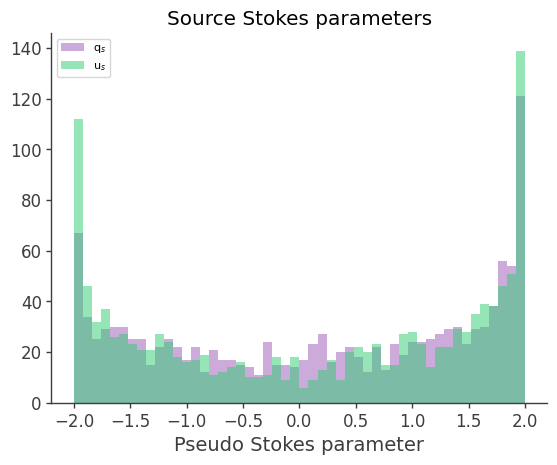

In [6]:
qs, us = source_photons.compute_pseudo_stokes(az_ang, show=True)
np.save('qs.npy', qs)
np.save('us.npy', us)

In [7]:
unpol_qs, unpol_us = source_photons.create_unpolarized_pseudo_stokes(TOT_NUM_EVENTS, show=True)
np.save('unpol_qs.npy', unpol_qs)
np.save('unpol_us.npy', unpol_us)

In [8]:
mu, mu_err = source_photons.calculate_average_mu(bins=20, show=True) 

Compute the expected MDP assuming a background rate

In [9]:
# Compute the MDP for this observation, assuming a bkg rate

mdp = source_photons.calculate_mdp(TOT_NUM_EVENTS, mu, bkg_rate=22.0)
print('\nMDP:', mdp*100, '%')

Calculating the MDP...
Espoure: 12.999999999998863 s
Total number of events: 1305
Modulation factor: 0.31
Background rate: 22.0 ph/s
MDP_99%: 49.0599013039517 %

MDP: 49.0599013039517 %


modularion factor: 0.31 +/- 0.001
-------  Q/I, U/I -0.5680315857794365 0.37067849501243155


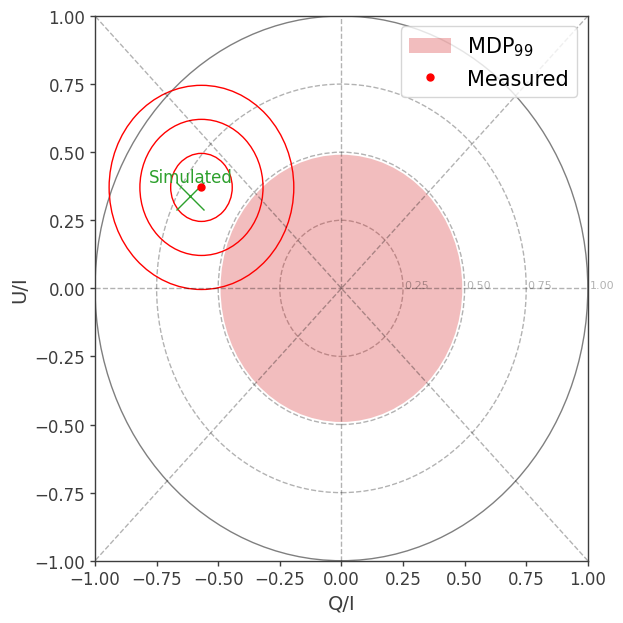

PD: 67.83 +/- 12.49 %
PA: 79.641 +/- 5.336


In [10]:
print('modularion factor:', mu, '+/-', mu_err)
polarization = source_photons.calculate_polarization(qs, us, unpol_qs, unpol_us, mu, show=True, ref_pdpa=(0.7, 83), ref_label='Simulated', mdp=mdp)

Transform polarization angle to different conventions

In [11]:
print('RelativeX:', round(polarization['angle'].transform_to(MEGAlibRelativeX(attitude=attitude)).angle.degree, 3), 'degrees')
print('RelativeY:', round(polarization['angle'].transform_to(MEGAlibRelativeY(attitude=attitude)).angle.degree, 3), 'degrees')
print('RelativeZ:', round(polarization['angle'].transform_to(MEGAlibRelativeZ(attitude=attitude)).angle.degree, 3), 'degrees')
print('IAU:', round(polarization['angle'].transform_to(IAUPolarizationConvention()).angle.degree, 3), 'degrees')

RelativeX: 106.626 degrees
RelativeY: 16.626 degrees
RelativeZ: 106.626 degrees
IAU: 79.641 degrees
